In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS

%matplotlib inline

# Understanding the shape of data

In [7]:
ls

eda.ipynb


In [10]:
# Load the data 
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [11]:
# First, let's count how much data we have !
train_len, test_len = len(train.index), len(test.index)
print(f'train_size : {train_len}, teset_size: {test_len}')

train_size : 1804874, teset_size: 97320


In [12]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [13]:
# let's look at couple of exmaples
k = 5
comments = [ train.iloc[i].comment_text for i in range(k)]
print(comments)

["This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!", "Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!", 'This is such an urgent design problem; kudos to you for taking it on. Very impressive!', "Is this something I'll be able to install on my site? When will you be releasing it?", 'haha you guys are a bunch of losers.']


# Get additional features

Some features might have relations with Toxicity, like capital letters in the text, punctuations in the texts. Add the new features into the training set.

In [15]:
train['total_length'] = train['comment_text'].apply(len)
train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)
train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
train['num_punctuation'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train['num_symbols'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
train['num_unique_words'] = train['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
train['words_vs_unique'] = train['num_unique_words'] / train['num_words']
train['num_smilies'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [16]:
features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols')
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit','identity_annotator_count', 'toxicity_annotator_count')
rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

In [17]:
train_correlations

,target,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
total_length,0.006444,0.007962,0.009823,0.053430,0.009085,-0.013198,-0.084710,0.002572,-0.019940,0.060639,0.017617,0.019882,0.020840,-0.030894
capitals,0.026120,0.025127,0.027995,0.050489,0.026358,0.000721,-0.039221,0.009687,-0.005448,0.018707,0.003928,0.014144,0.012405,-0.009082
caps_vs_length,-0.005344,0.010594,0.017088,-0.008477,-0.006029,0.000822,0.021263,-0.000603,0.002848,-0.038470,-0.021716,-0.003575,-0.005510,0.015381
num_exclamation_marks,0.055152,0.035388,0.056108,0.017085,0.052533,0.021267,0.007073,0.002225,0.005158,-0.007866,-0.009384,0.019437,0.000869,0.024115
num_question_marks,0.019308,0.011662,0.019233,0.028554,0.014366,-0.000430,-0.009290,0.001263,0.002023,-0.002731,-0.002180,0.015987,0.006305,-0.003307
num_punctuation,0.016974,0.013266,0.017701,0.042990,0.018911,-0.006479,-0.057187,0.001959,-0.016511,0.029581,0.001415,0.018985,0.018050,-0.021231
num_words,0.009579,0.009696,0.014536,0.050527,0.011975,-0.009893,-0.084398,0.002714,-0.019412,0.059481,0.016121,0.021525,0.020595,-0.029856
num_unique_words,0.016702,0.011900,0.017918,0.053659,0.019494,-0.008946,-0.085764,0.003490,-0.018110,0.063874,0.019634,0.022816,0.020787,-0.029814
words_vs_unique,0.001172,-0.005329,-0.003007,-0.048941,0.001135,0.009367,0.079045,-0.004150,0.016223,-0.060162,-0.020712,-0.015748,-0.019749,0.027853
num_smilies,-0.010040,-0.003877,-0.001024,-0.008337,-0.009401,-0.003190,0.010109,-0.002777,-0.002133,-0.016607,-0.010936,-0.000414,-0.000576,-0.003030


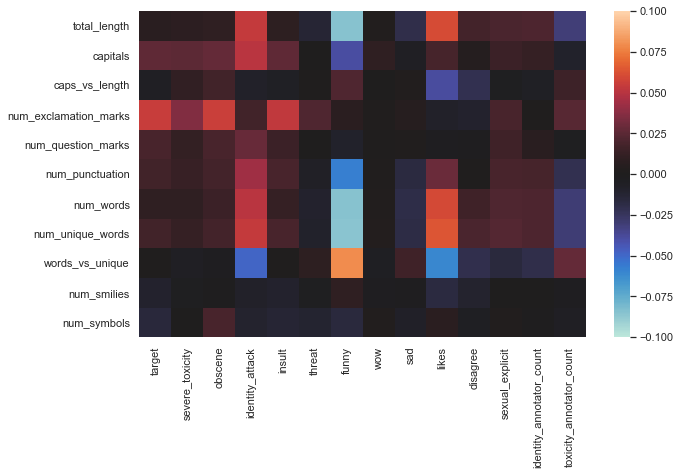

In [18]:
# Correlations between new features and targets in heatmap:

plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)

percent of toxic comments related to different identities, using target and population amount of each identity as weights

In [24]:
demographics = train.loc[:, ['target']+list(train)[slice(8, 32)]].dropna()

In [40]:
weighted_toxic = demographics.iloc[:,1:].multiply(demographics.iloc[:,0],axis='index').sum(axis=0)/demographics.iloc[:,1:][demographics.iloc[:,1:] > 0].count()

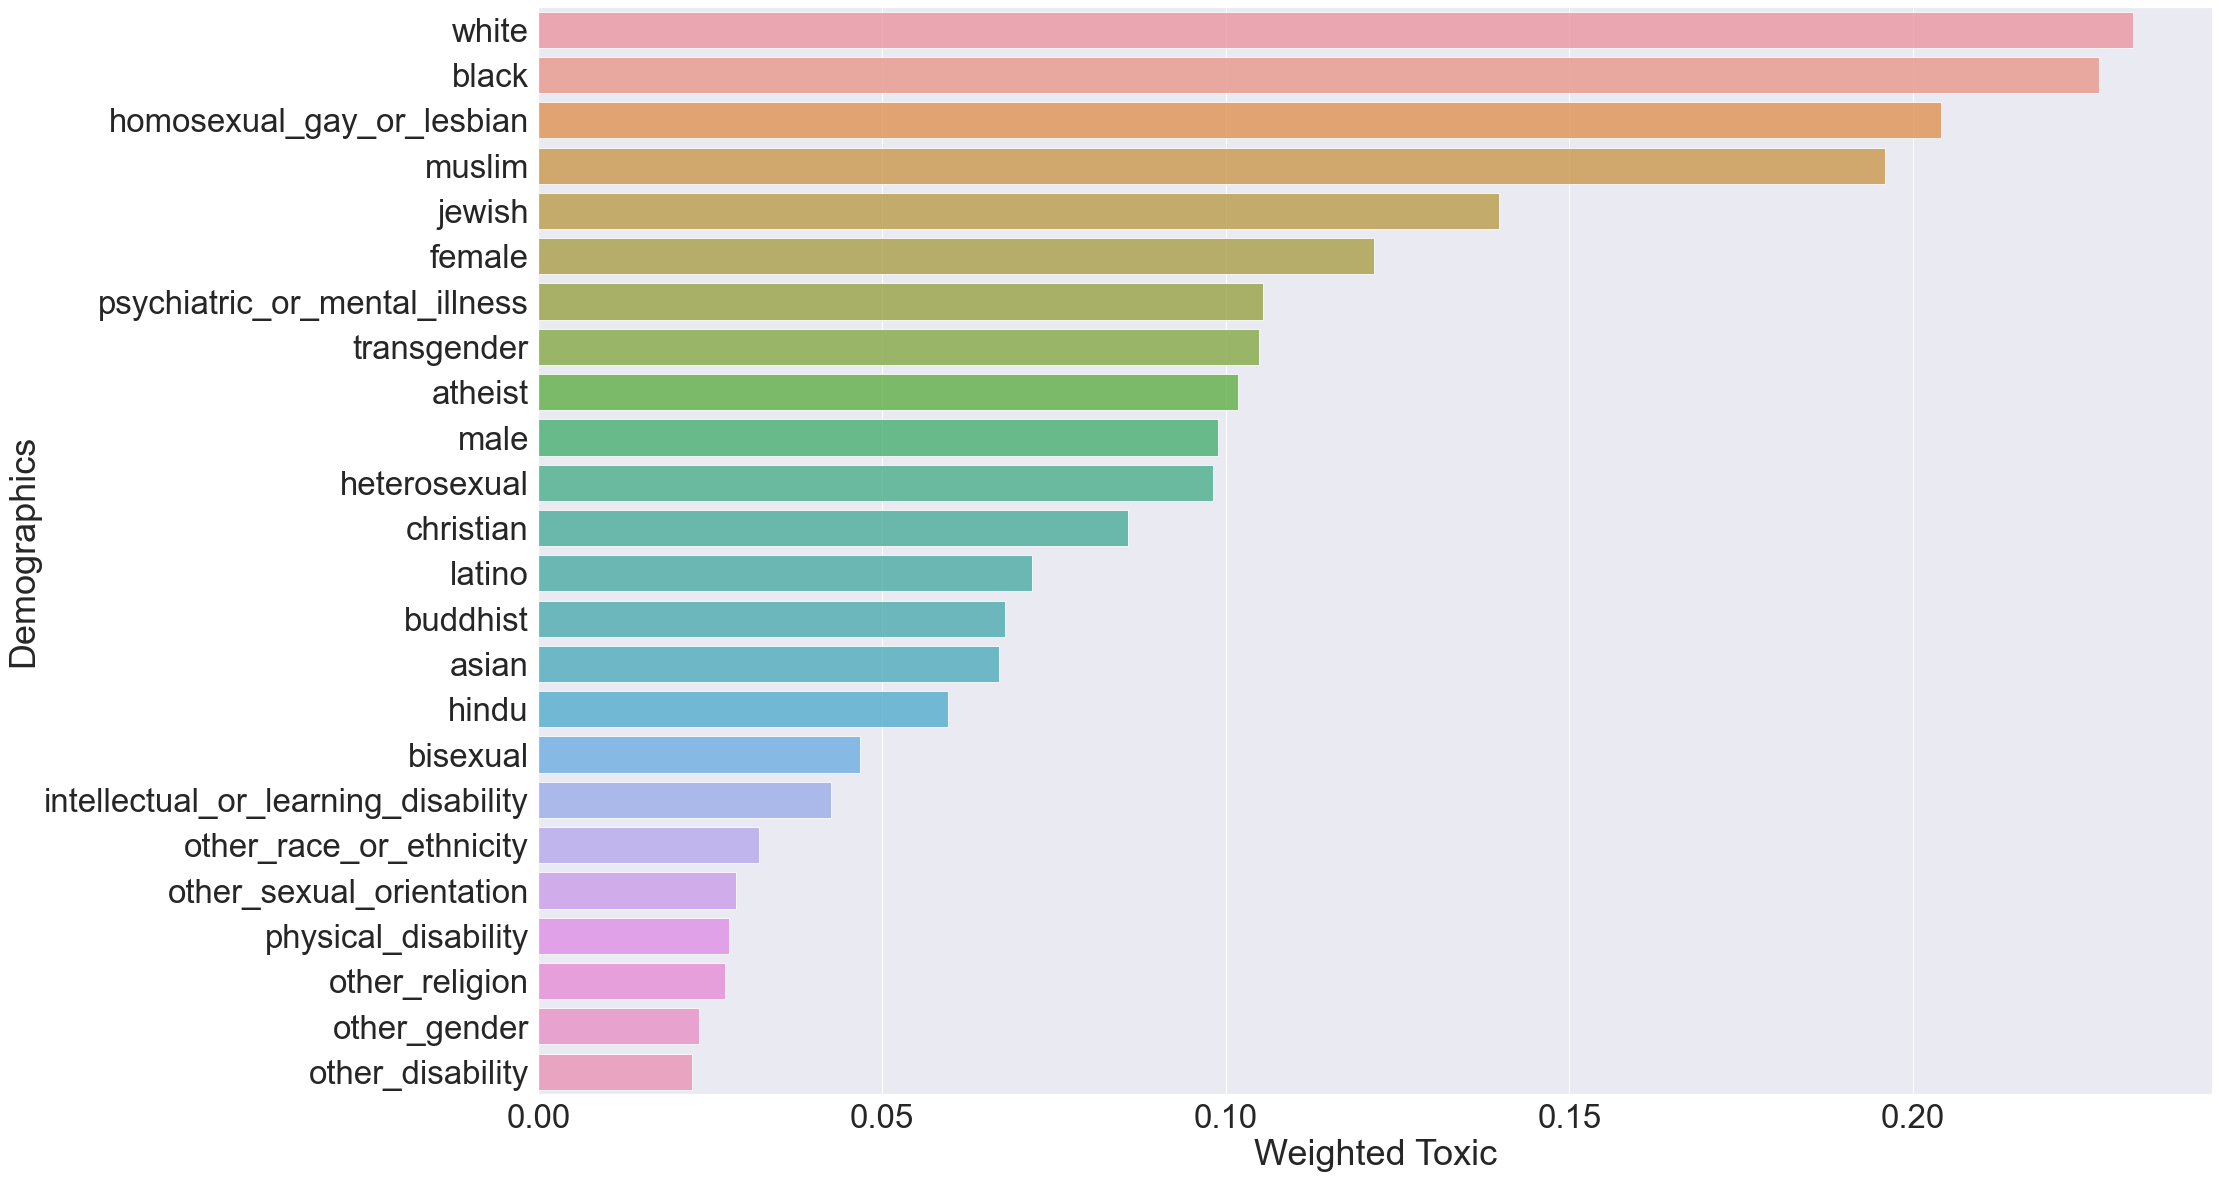

In [41]:
weighted_toxic = weighted_toxic.sort_values(ascending=False)
plt.figure(figsize=(30, 20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values, y=weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxic')
plt.show()

Meanwhile, we can check the correlations between identities and the comment labels.

In [42]:
identities = tuple(train.iloc[:, 8:32])
rows = [{c: train[f].corr(train[c]) for c in columns} for f in identities]
poptoxicity_correlations = pd.DataFrame(rows, index=identities)

In [43]:
poptoxicity_correlations

,target,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
asian,0.007205,0.005371,-0.004047,0.041203,-0.000664,-0.002817,-0.000409,0.010691,0.001051,-0.003144,0.007868,-0.013710,0.021327,0.001216
atheist,0.010625,0.005047,-0.000122,0.031167,0.005152,0.000781,-0.002847,-0.002600,0.000051,-0.002436,0.001031,-0.004954,0.023635,-0.000433
bisexual,0.021057,0.009279,0.005323,0.047476,0.006283,-0.001796,-0.003230,-0.000367,-0.002987,0.009078,-0.004104,0.024218,0.015360,-0.000380
black,0.167224,0.094418,0.026267,0.314422,0.098186,0.048630,-0.020852,0.001483,0.004480,-0.012769,-0.000631,-0.006407,0.018075,0.035702
buddhist,0.004613,0.004260,-0.001751,0.024143,-0.002909,0.002542,-0.002802,-0.001222,-0.001348,-0.000621,-0.001719,-0.004397,0.010600,-0.002119
christian,-0.006776,-0.000874,-0.025650,0.093885,-0.030669,-0.014324,-0.008460,-0.013146,-0.015212,0.021608,-0.020644,0.008710,0.018038,-0.015846
female,0.062904,0.032653,0.036250,0.052299,0.037995,0.023384,-0.012743,0.008052,0.005052,0.036137,0.008464,0.153735,0.009830,0.007588
heterosexual,0.038193,0.018239,0.008396,0.073282,0.012613,-0.003600,-0.002225,-0.001381,-0.001339,0.006148,-0.002821,0.066624,0.010674,0.003018
hindu,0.003607,0.003839,-0.002221,0.022695,-0.001895,0.001549,-0.002369,-0.000161,-0.001025,0.002924,0.002689,-0.005251,0.014825,-0.001248
homosexual_gay_or_lesbian,0.131110,0.064122,0.026097,0.249880,0.061920,0.016785,-0.003616,-0.001935,0.003452,0.012015,-0.002378,0.099424,0.020577,0.019139


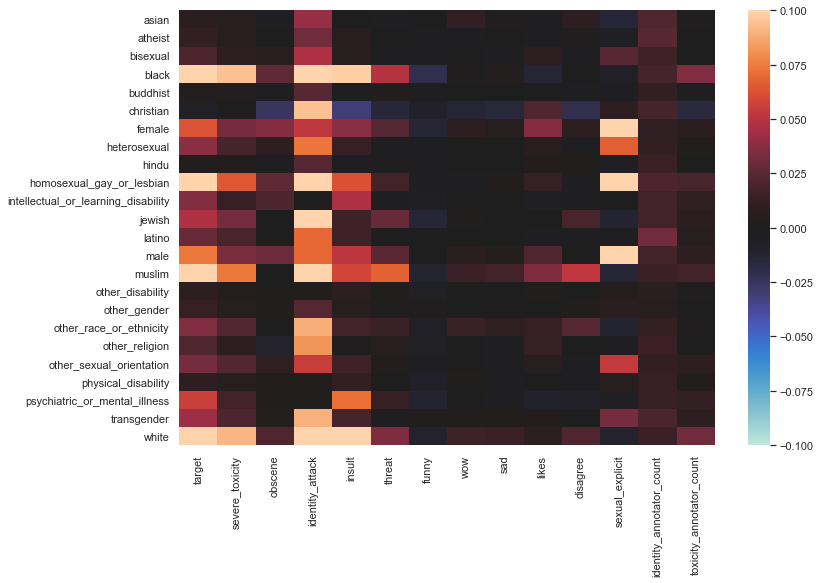

In [44]:
# Heatmap for the correlations
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
ax = sns.heatmap(poptoxicity_correlations, vmin=-0.1, vmax=0.1, center=0.0)

In [45]:
import gc
del train_correlations
del poptoxicity_correlations

In [46]:
gc.collect()

14726

# Time Series analysis of comments made

In [47]:
# Lets again create a list of all the identities tagged in this dataset. This list given in the data section of this competition. 

identities_all = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']


In [48]:
withdate = train.loc[:, ['created_date', 'target'] + identities_all].dropna()
raceweighted = withdate.iloc[:, 2:]/withdate.iloc[:, 2:].sum()
race_target_weighted = raceweighted.multiply(withdate.iloc[:,1], axis='index')

race_target_weighted['comment_count'] = 1

# now we add the date to our newly created dataframe (also parse the text date as datetime)
race_target_weighted['created_date'] = pd.to_datetime(withdate['created_date']).values.astype('datetime64[M]')
weighted_demo = race_target_weighted.groupby(['created_date']).sum().sort_index()


In [53]:
# Importing plotly credentials for time series datavisualizations

import plotly
import chart_studio
import chart_studio.plotly as py
import cufflinks as cf
import plotly.graph_objs as go
chart_studio.tools.set_credentials_file(username='raisul_bd', api_key='gkmwlmRYR0UBe11MnK4O')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [58]:
weighted_demo[['white', 'asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity']].iplot(title = 'Time Series Toxicity & Race', filename='Time Series Toxicity & Race' )

# Click on the legend to change display. Double click for single identity.

> Here we see the relative weighted toxic score for each identity of races of two years span.

In [59]:
weighted_demo[['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion']].iplot(title = 'Time Series Toxicity & Religion', filename='Time Series Toxicity & Religion')

> Here we see toxic score for sexual orientation

In [60]:
weighted_demo[['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']].iplot(title = 'Time Series Toxicity & Sexual Orientation', filename='Time Series Toxicity & Sexual Orientation')

In [61]:
weighted_demo[['male', 'female', 'transgender', 'other_gender']].iplot(title = 'Time Series Toxicity & Gender', filename='Time Series Toxicity & Gender')

# Click on the legend to change display. Double click for single identity.

In [62]:
weighted_demo[['physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']].iplot(title = 'Time Series Toxicity & Disability', filename='Time Series Toxicity & Disability')

# Click on the legend to change display. Double click for single identity.

# Zooming into the peaks

Observation: After plotting these chartgs, we have found that most data have a peak around Jan 2017. A bit curious. Let's check what is the difference between Jan 2017 and other time.